### Integrating Bayesian Optimization in Custom Functions

In [2]:
import sys

In [3]:
sys.path.insert(0,'/KIMEL/tigrlab/projects/jjeyachandra/gmsh-sdk/lib/')
sys.path.insert(0,'/home/jjeyachandra/simnibs_2.1.2/miniconda2/envs/simnibs_env/lib/python2.7/site-packages')
sys.path.insert(0,'/home/jjeyachandra/simnibs_2.1.2/Python_modules/src')

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib 

Using matplotlib backend: TkAgg


In [5]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
sys.path.insert(0, '/projects/jjeyachandra/Cornell-MOE')

In [7]:
#Define some testing functions in low dimensional space to check for convergence
@np.vectorize
def six_camel(x,y):
    
    return (4 - 2.1*(x**2) + (x**4)/3 )*(x**2) + x*y + (-4 + 4*(y**2))*(y**2)

In [8]:
#Visualize the objective function over the domain
Dx = np.linspace(-2,2,100,dtype=np.float64)
Dy = np.linspace(-1,1,100,dtype=np.float64)
xx,yy = np.meshgrid(Dx,Dy)
result = six_camel(xx,yy)

In [9]:
#Do full contour evaluation
Cx = np.linspace(-3,3,100,dtype=np.float64)
Cy = np.linspace(-1,1,100,dtype=np.float64)
cxx,cyy = np.meshgrid(Cx,Cy)
cresult = six_camel(cxx,cyy)

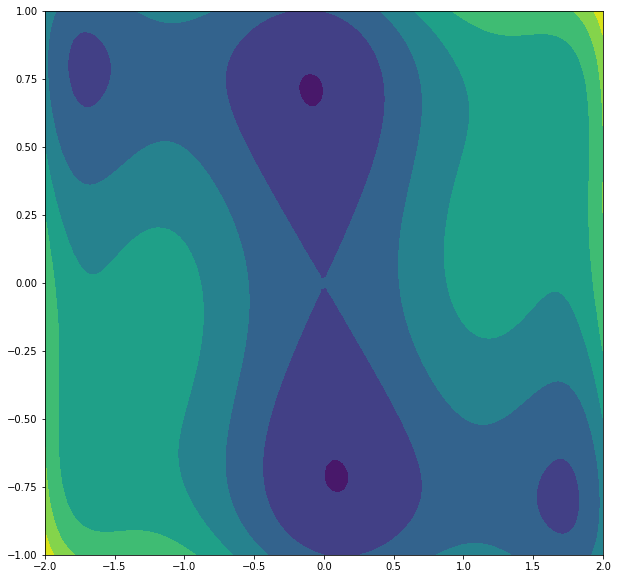

In [10]:
#Visualize on matplotlib surface plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.contourf(xx,yy,result)

(-2, 5)

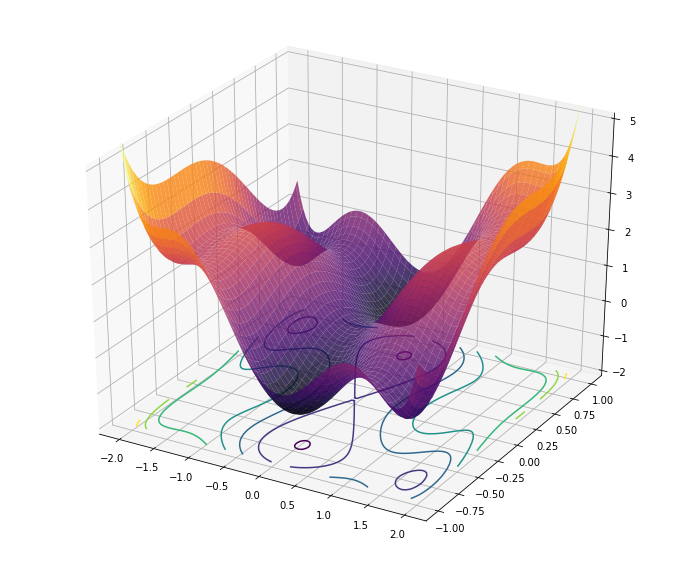

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(xx,yy,result,cmap='inferno',alpha=0.8)
ax.contour(xx,yy,result, offset=-2)
ax.set_zlim(-2,5)

In [44]:
from moe.optimal_learning.python.cpp_wrappers.domain import TensorProductDomain as cTensorProductDomain
from moe.optimal_learning.python.python_version.domain import TensorProductDomain
from moe.optimal_learning.python.geometry_utils import ClosedInterval

search_domain = TensorProductDomain([ClosedInterval(-3,3), ClosedInterval(-2,2)])
cpp_search_domain = cTensorProductDomain([ClosedInterval(-3,3), ClosedInterval(-2,2)])

In [45]:
from moe.optimal_learning.python.cpp_wrappers.expected_improvement import ExpectedImprovement
from moe.optimal_learning.python.cpp_wrappers.expected_improvement import multistart_expected_improvement_optimization as meio

def gen_sample_from_qei(gp,search_domain,sgd_params,num_samples, num_mc=1e4, lhc_iter=2e4):
    
    qEI = ExpectedImprovement(gaussian_process=gp, num_mc_iterations=int(num_mc))
    optimizer = cGDOpt(search_domain, qEI, sgd_params, int(lhc_iter))
    points_to_sample = []
    ei_list = []
    
    points_to_sample.append(meio(optimizer, None, num_samples,use_gpu=False,which_gpu=0,
                                max_num_threads=8))
    
    
    qEI.set_current_point(points_to_sample[0])
    ei_list.append(qEI.compute_expected_improvement())
    return points_to_sample[0], ei_list[0]

In [49]:
num_init_pts = 5
init_pts = np.zeros( (num_init_pts, 2) )
init_pts[:, :2] = search_domain.generate_uniform_random_points_in_domain(num_init_pts)

In [50]:
observations = six_camel(init_pts[:,0],init_pts[:,1])

(-5, 5)

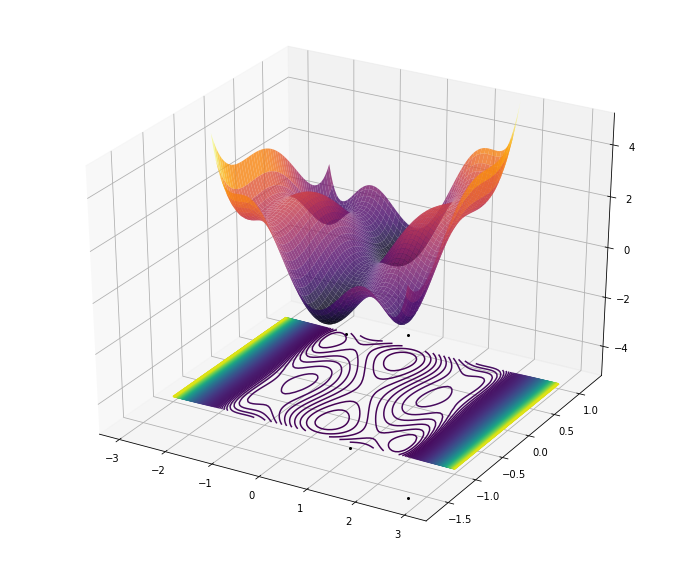

In [52]:
#Plot observations on 3D surface
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(xx,yy,result,cmap='inferno',alpha=0.8,label='six-camel')
ax.contour(cxx,cyy,cresult, offset=-5, label='contour projection',levels=np.linspace(-2,300,700))
ax.plot3D(init_pts[:,0],init_pts[:,1],-5*np.ones_like(observations),'k.',markersize=4, label='init_sample')
ax.set_zlim(-5,5)


In [53]:
from moe.optimal_learning.python.data_containers import HistoricalData, SamplePoint
init_data = HistoricalData(dim = 2, num_derivatives=0)
init_data.append_sample_points([SamplePoint(pt, o, 0.0) for pt,o in zip(init_pts,observations)])

In [54]:
from moe.optimal_learning.python.cpp_wrappers.log_likelihood_mcmc import GaussianProcessLogLikelihoodMCMC
from moe.optimal_learning.python.default_priors import DefaultPrior
prior = DefaultPrior(n_dims=2 + 2,num_noise=1)
gp_ll = GaussianProcessLogLikelihoodMCMC(historical_data=init_data,derivatives = [],
                                        prior=prior, chain_length=1000, burnin_steps=2000,
                                        n_hypers=2**4, noisy=False, rng=20)
## n_hypers is a lower-limit on the number of MCMC chains to use
gp_ll.train()

In [55]:
from moe.optimal_learning.python.python_version.optimization import GradientDescentOptimizer, GradientDescentParameters
from moe.optimal_learning.python.cpp_wrappers.optimization import GradientDescentOptimizer as cGDOpt
from moe.optimal_learning.python.cpp_wrappers.optimization import GradientDescentParameters as cGDParams
sgd_params = cGDParams(num_multistarts=200, 
                       max_num_steps=50,
                       max_num_restarts=2,
                       num_steps_averaged=4,
                       gamma=0.7,
                       pre_mult=1.0,
                       max_relative_change=0.5,
                       tolerance=1.0e-10)

In [56]:
from IPython.display import clear_output, display
num_iters = 50
optimum = -1.0316
n_samp = 4

In [57]:

for i in np.arange(0,20):   
    
    points_to_sample,ei = gen_sample_from_qei(gp_ll.models[0], cpp_search_domain, sgd_params=sgd_params,
                                              num_samples=8,num_mc=2**10)
    #Evaluate underlying objective function at these points
    sampled_points = [six_camel(x[0],x[1]) for x in points_to_sample]

    #Build list of sampled points
    evidence_tup = [ SamplePoint(c,v,0.0) for c,v in zip(points_to_sample, sampled_points)] 

    #Add to GPLogLikelihoodMaximization and re-train new model
    gp_ll.add_sampled_points(evidence_tup)
    gp_ll.train()

    #Pull model being trained and compute errors
    gp = gp_ll.models[1]
    min_point = np.argmin(gp._points_sampled_value)
    min_val = np.min(gp._points_sampled_value)
    best_coord = gp.get_historical_data_copy().points_sampled[min_point,:]
    error = np.abs(min_val - optimum)

    #Print out useful information
    clear_output()
    print('Recommended Points:')
    print(points_to_sample)
    print('Expected Improvement: {}'.format(ei))
    print('Current Best:')
    print('Coord:', best_coord)
    print('f(x*)=', min_val)
    print('Error:', error)

Recommended Points:
[[-0.75753052  0.82275938]
 [-2.3356589   1.03472707]
 [-1.76584152  0.07509134]
 [-0.27947779 -0.85374687]
 [ 0.08867532 -0.7042295 ]
 [ 2.66625641 -0.28385087]
 [ 2.30461101 -0.54705776]
 [ 2.82433355  1.4329414 ]]
Expected Improvement: 0.000811741145789
Current Best:
('Coord:', array([-0.09072352,  0.71451357]))
('f(x*)=', -1.0315987438532823)
('Error:', 1.2561467177540919e-06)


In [21]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


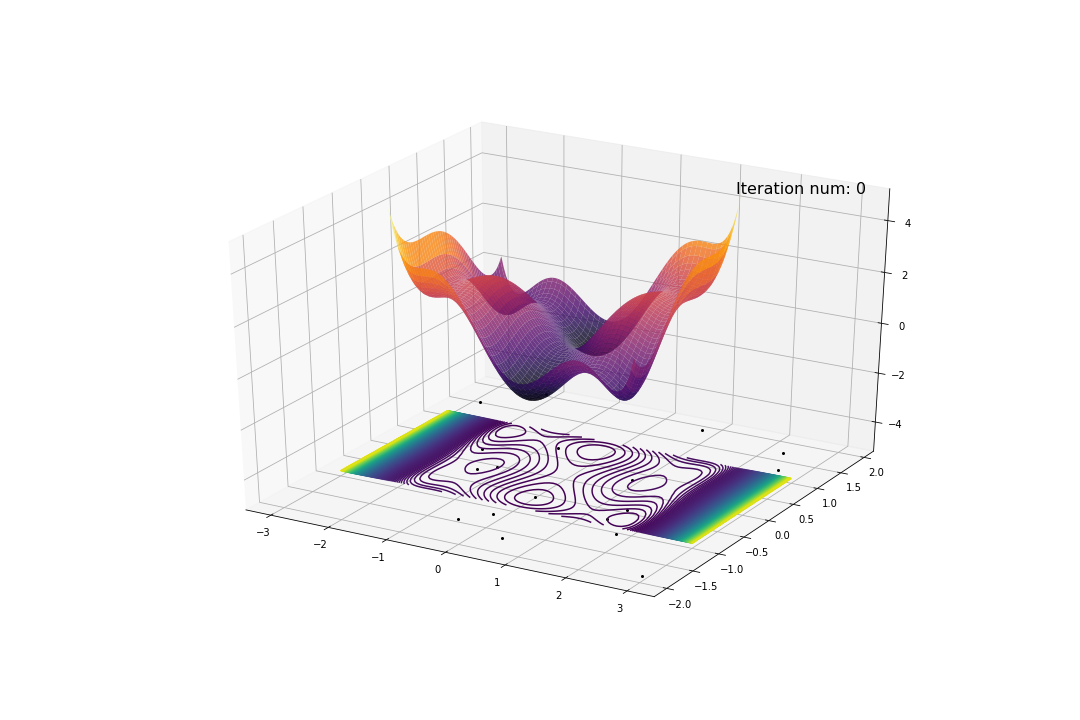

In [263]:
#Make canvas
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111,projection='3d')

#Initialize input arrays
init_xarr = np.empty( (n_samp*num_iters) )
init_yarr = np.empty( (n_samp*num_iters) )
init_zarr = np.empty( (n_samp*num_iters) )

init_xarr[:] = np.nan
init_yarr[:] = np.nan
init_zarr[:] = np.nan

line, = ax.plot3D(init_xarr, init_yarr, init_zarr,'k.',markersize=4)

#Make base plots
ax.plot_surface(xx,yy,result,cmap='inferno',alpha=0.8,label='six-camel')
ax.contour(cxx,cyy,cresult, offset=-5, label='contour projection',levels=np.linspace(-2,300,700))
ax.plot3D(init_pts[:,0],init_pts[:,1],-5*np.ones_like(observations),'k.',markersize=4, label='init_sample')
ax.set_zlim(-5,5)

#Text data
txt = ax.text3D(1.5,1.5,5,'Iteration num: 0',fontsize=16)

#Define animation functions
def init():
    return line

def update_plot(i):
    
    print(i)
    #Generate samples to train model
    points_to_sample, ei = gen_sample_from_qei(gp_ll.models[0], cpp_search_domain, sgd_params=sgd_params,
                                              num_samples=n_samp, num_mc=2**10)
    sampled_points = [six_camel(x) for x in points_to_sample]
    evidence_tup = [ SamplePoint(c,v,0.0) for c,v in zip(points_to_sample, sampled_points)]
    gp_ll.add_sampled_points(evidence_tup)
    gp_ll.train()
    
    #Fill in samples to animation
    init_xarr[i*n_samp:(i*n_samp)+n_samp] = points_to_sample[:,0]
    init_yarr[i*n_samp:(i*n_samp)+n_samp] = point_to_sample[:,1]
    init_zarr[i*n_samp:(i*n_samp)+n_samp] = 0
    line.set_xdata(init_xarr)
    line.set_ydata(init_yarr)
    line.set_3d_properties(init_zarr)
    
    #Update text
    txt.set_text('Iteration num: {}'.format(i))
    
    return line, txt

ani = animation.FuncAnimation(fig, update_plot, init_func=init, blit=False,frames=n_samp)

    
    